In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as md
import requests
import io


pd.plotting.register_matplotlib_converters()
dateformat=md.DateFormatter('%d-%m\n%Y')

## Scaricamento dati
Dati scaricati dall'account ufficiale Github

In [3]:
rcons = requests.get('https://raw.github.com/italia/covid19-opendata-vaccini/master/dati/consegne-vaccini-latest.json')
rsom = requests.get('https://raw.github.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-latest.json')

## preparazione preliminare dati

In [4]:
# consegne, ordinate per data consegna
tmp=rcons.json()
consegne=pd.DataFrame(tmp['data'])
consegne['data_consegna']=pd.to_datetime(consegne['data_consegna'].apply(lambda x: x[:10]))
consegne.sort_values(by='data_consegna',inplace=True)

# somministrazioni, ordinate per data somministrazione
tmp=rsom.json()
somminis=pd.DataFrame(tmp['data'])
somminis['data_somministrazione']=pd.to_datetime(somminis['data_somministrazione'].apply(lambda x: x[:10]))
somminis.sort_values(by='data_somministrazione',inplace=True)

idx = pd.date_range(consegne['data_consegna'].iloc[0], consegne['data_consegna'].iloc[-1])
areas=list(set(consegne['area']))
forn=list(set(consegne['fornitore']))
forn=[ 'Pfizer/BioNTech','Moderna', 'AstraZeneca']

## estrazione dei dati totali per regione e fornitore
Per ogni area:
* estrazione del numero di consegne e di somministrazioni totali per ogni giorno
* un dataframe preparato per ogni area con indice il giorno

In [5]:
consegne_forn={}
somminis_forn={}
for area in areas:
    out={}
    for f in forn:
        tmp=consegne[(consegne['area']==area) & (consegne['fornitore']==f)]
        tmp.set_index('data_consegna', inplace=True)
        out[f]=tmp[['numero_dosi']].reindex(idx, fill_value=0)

    consegne_forn[area]=pd.concat(out,axis=1)
    consegne_forn[area].columns=consegne_forn[area].columns.droplevel(1)


    out={}
    for f in forn:
        tmp=somminis[(somminis['area']==area) & (somminis['fornitore']==f)]
        tmp=tmp.groupby(tmp['data_somministrazione'].dt.date).sum()
        tmp['tot_dosi']=tmp['prima_dose']+tmp['seconda_dose']
        out[f]=tmp[['tot_dosi']].reindex(idx, fill_value=0)

    somminis_forn[area]=pd.concat(out,axis=1)
    somminis_forn[area].columns=somminis_forn[area].columns.droplevel(1)

## consolidamento dei dati in un dataframe multindex
Andamento medio settimanale delle giacenze di vaccini (cumulativi consegnati - cumulativi somministrati) per regioni e per fornitore


In [6]:
consegne_forn_tot=pd.concat(consegne_forn,axis=1)
somminis_forn_tot=pd.concat(somminis_forn,axis=1)
magazzino_forn_tot=consegne_forn_tot.cumsum()-somminis_forn_tot.cumsum()

magazzino_forn_tot_w=magazzino_forn_tot.resample('W').mean()

## grafico per regioni
Il grafico rappresenta con barre divise per fornitore quante dosi cumulative rimangono in giacenza ogni settimana

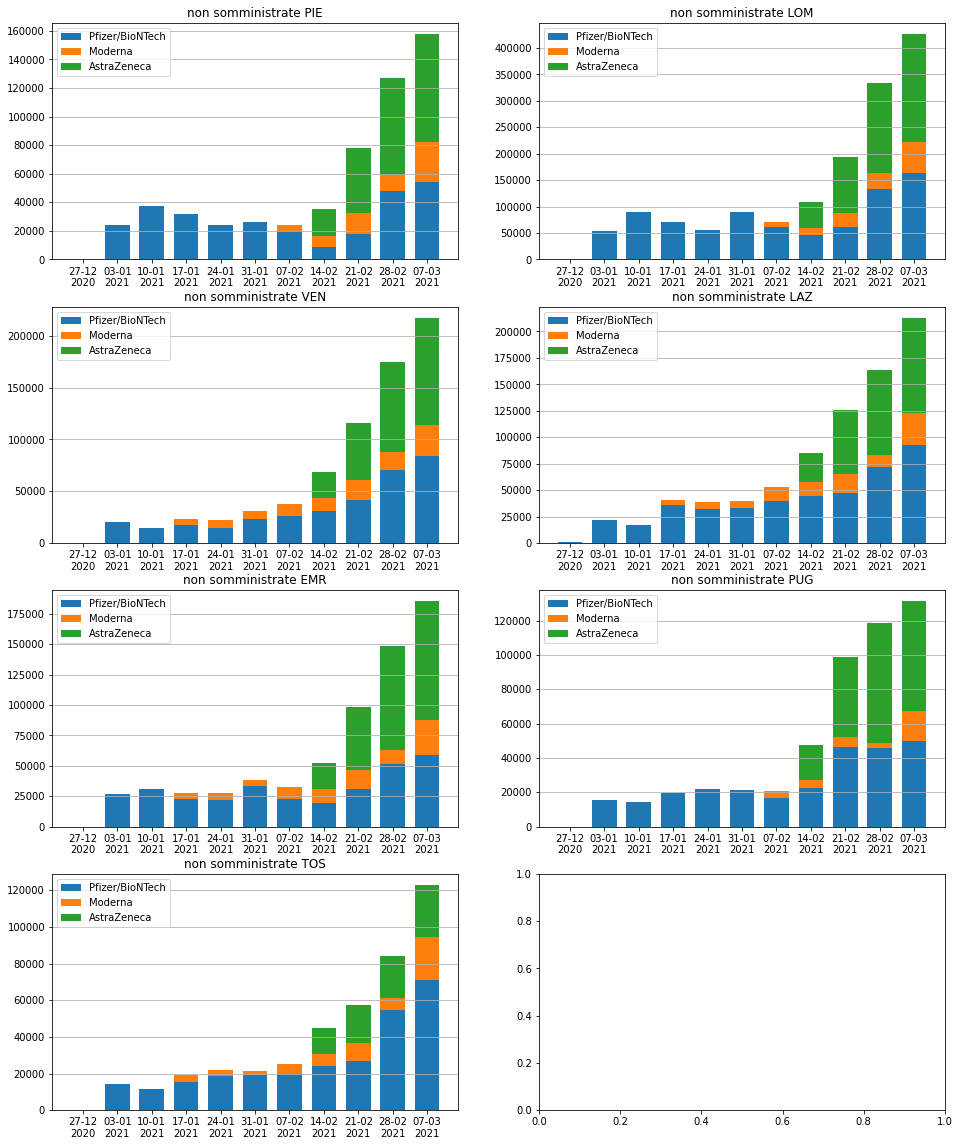

In [7]:
areas_ana=['PIE','LOM','VEN','LAZ','EMR','PUG','TOS']
nrows=int(np.ceil(len(areas_ana)/2))
fig,axs=plt.subplots(nrows,2,figsize=(16,nrows*5))
axs=[xx for xx1 in axs for xx in xx1]
for ax,area in zip(axs,areas_ana):
    f_cumul=[]
    for f in forn:
        ax.bar(magazzino_forn_tot_w.index,magazzino_forn_tot_w[area,f],5.,bottom=(magazzino_forn_tot_w[area])[f_cumul].sum(axis=1))
        f_cumul.append(f)
    ax.xaxis.set_major_formatter(dateformat)
    ax.set_xticks(magazzino_forn_tot_w.index)
    ax.grid(True, axis="y")
    ax.legend(forn)
    ax.set_ylim(0,None)
    ax.set_title('non somministrate ' + area)

## grafico Italia

Il grafico rappresenta con barre divise per fornitore quante dosi cumulative rimangono in giacenza ogni settimana in Italia

Text(0.5, 1.0, 'non somministrate Italia')

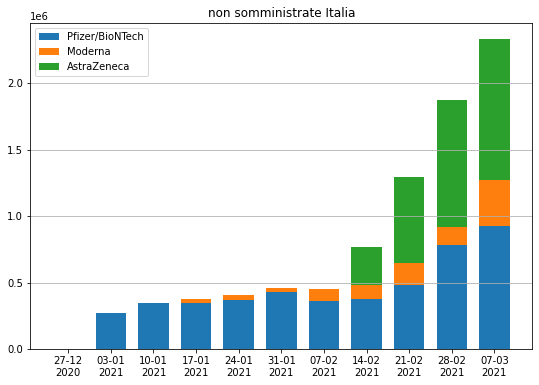

In [8]:
fig,ax=plt.subplots(figsize=(9,6))
magazzino_forn_tot=consegne_forn_tot.cumsum()-somminis_forn_tot.cumsum()
magazzino_forn_tot_w=magazzino_forn_tot.resample('W').mean()
magazzino_forn_ita_w=magazzino_forn_tot_w.sum(axis=1,level=1)
f_cumul=[]
for f in forn:
    ax.bar(magazzino_forn_ita_w[f].index,magazzino_forn_ita_w[f],5.,bottom=magazzino_forn_ita_w[f_cumul].sum(axis=1))
    f_cumul.append(f)
ax.xaxis.set_major_formatter(dateformat)
ax.set_xticks(magazzino_forn_ita_w.index)
ax.grid(True, axis="y")
ax.legend(forn)
ax.set_ylim(0,None)
ax.set_title('non somministrate Italia')